In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.models import Sequential

from sklearn.preprocessing import StandardScaler

import seaborn as sns

In [2]:
#Reset backend for next interation?
tf.keras.backend.clear_session()

df = pd.read_csv('file:///C:/Users/Mher/Documents/Stock-Prediction-Machine-Learning/AAPL.csv')
df.shape

(1259, 7)

In [3]:
#extract dates for future plotting
#returns date as an object so we converted datetime for ploting purposes
train_dates = pd.to_datetime(df['Date'])

In [4]:
#variables for training
#extracting the columns that we want to use as variables
cols = list(df)[1:7]

In [5]:
#this is the new df, same as old but without date and volume was converted 
#to float so later when we do normalization we wont lose any info
df_for_training = df[cols].astype(float)

In [6]:
#scaling the data
#LSTM uses sigmoid and tanh that are sensitive to magnitude, so values need to be normalized
#normalize the dataset using StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(df_for_training) #fitting the scaler
df_for_training_scaled = scaler.transform(df_for_training)

In [7]:
#very important part to get the input shape ready
#As required for LSTM netowrks, we require to reshape the inpuit data into chunks
#In this example, the n_features is 6/ we will make timesteps = 1

In [8]:
#tryng to capture mour? training series
trainX = [] #is the training series (window width or number of past days)
trainY = [] #is the y prediction

n_future = 1
n_past = 14

In [9]:
#to populate our training x series
for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [10]:
#convert list into arrays
trainX, trainY = np.array(trainX), np.array(trainY)

In [11]:
#shape that is going into the LSTM
print("Shape going into LSTM")
print("trainX shape == {}".format(trainX.shape)) #(data points, 14 days looking back, 5 variables)
print("trainY shape == {}".format(trainY.shape)) #((xxx, 1) b/c we are only predicting the next day)

Shape going into LSTM
trainX shape == (1245, 14, 6)
trainY shape == (1245, 1)


In [12]:
#define autoencoder model

In [13]:
model = Sequential()
#LSTM has 64 units
#trainX.shape 1 and trainXshape 2 ==(14,6)
#sequence is set to trueso it can return a sequence for the next LSTM to process
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
#return sequence is false b/c the next layer is a dropout layer
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

In [14]:
#....
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 64)            18176     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
70/70 [==============================] - 1s 16ms/step - loss: 0.1203 - val_loss: 0.0471
Epoch 2/10
70/70 [==============================] - 1s 13ms/step - loss: 0.0342 - val_loss: 0.0262
Epoch 3/10
70/70 [==============================] - 1s 12ms/step - loss: 0.0228 - val_loss: 0.0285
Epoch 4/10
70/70 [==============================] - 1s 12ms/step - loss: 0.0206 - val_loss: 0.0322
Epoch 5/10
70/70 [==============================] - 1s 12ms/step - loss: 0.0233 - val_loss: 0.0357
Epoch 6/10
70/70 [==============================] - 1s 12ms/step - loss: 0.0242 - val_loss: 0.0405
Epoch 7/10
70/70 [==============================] - 1s 12ms/step - loss: 0.0197 - val_loss: 0.0753
Epoch 8/10
70/70 [==============================] - 1s 12ms/step - loss: 0.0190 - val_loss: 0.0219
Epoch 9/10
70/70 [==============================] - 1s 12ms/step - loss: 0.0152 - val_loss: 0.0622
Epoch 10/10
70/70 [==============================] - 1s 12ms/step - loss: 0.0144 - val_loss: 0.0244


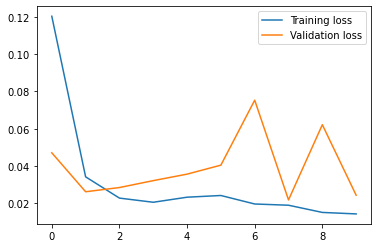

In [15]:
#fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [16]:
#forcasting
n_future = 5
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

forecast = model.predict(trainX[-n_future:])

In [17]:
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)

y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [18]:
#convert timestamps to dates
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

In [19]:
original = df[['Date', 'Open']]
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[(original['Date'] >= '2020-12-1')]

<ipython-input-19-bd44c4282584>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date'] = pd.to_datetime(original['Date'])


<AxesSubplot:xlabel='Date', ylabel='Open'>

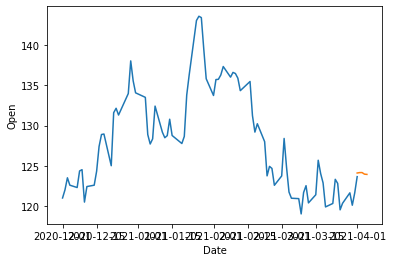

In [20]:
sns.lineplot(data=original, x='Date', y='Open')
sns.lineplot(data=df_forecast, x='Date', y='Open')